# Model Free Prediction

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from time import sleep
from IPython.display import clear_output
import math
import numpy.matlib
import random

## Marche aléatoire

Dans cet exemple simple, nous essayons d'évaluer la fonction de valeur des états correspondant à un problème de marche aléatoire. Ici, l'agent suit une politique aléatoire et peut aller soit à gauche avec une probabilité $p$ soit à droite avec une probabilité $1-p$. Il existe en tout $N$ cases sur lesquelles l'agent peut se déplacer ainsi que deux cases terminales d'où il ne peut pas repartir : 

$$ \square \overset{0}{\leftarrow} 1 \overset{0}{\longleftrightarrow} \cdots \overset{0}{\longleftrightarrow} N \overset{1}{\rightarrow} \blacksquare $$

La récompense de passer d'un état à l'autre est nul exceptée pour la terminaison de droite.

### Dynamic programming 

Ce problème est suffisament simple pour pouvoir êêtre calculé à la main (*cf.* cours). Ceci nous permettra dans ce cas de vérifier l'estimation obtenue. 

### First Visit Monte Carlo 

Une première façon d'estimer la fonction de valeur en chaque état est de générer plusieurs marches aléatoires en gardant en mémoire combien de fois les états ont été visités et pour quel valeur de retour. La moyenne du retour pour chaque état nous donne ainsi une estimation non biaisée de la fonction de valeur.

La fonction suivante donne le retour et le nombre de fois qu'un état à été visité (first-visite)

In [ ]:
def MC_random_walk(i0,N):
  Ns = np.zeros([N,1])
  i = i0
  G = np.zeros([N,1])
  Ns[i] = 1
  while i!=-1 and i!=N:
    pi = np.random.binomial(1, .5, 1)
    i = i+1 if pi==0 else i-1
    if i in range(N) and Ns[i]==0:
      Ns[i] = 1
    elif i==N:
      G[np.argwhere(Ns==1)[:,0]] = 1
  return Ns, G

#### Coding Task

Complétez le code suivant pour permettre l'estimation de la fonction d'état

In [ ]:
iter = 1000
Nb_states = 5
Ns = np.zeros([N,1])
G  = 0
for i in range(iter):
  MC_est = MC_random_walk(3,Nb_states)
  Ns = Ns + MC_est[0]
  G  = G  + MC_est[1]

V = G/Ns
V

array([[0.15696203],
       [0.3313253 ],
       [0.50812408],
       [0.667     ],
       [0.83375   ]])

### Temporal Difference-Learning

Plutôt que d'estimer le retour après chaque trajectoire, nous allons mettre à jour l'estimation de la fonction de valeur dès qu'un état est visité en s'appuyant sur l'équation de Bellman :

$$ V(S_t ) \leftarrow V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right] $$

Ici, nous prendrons les discount factors $\gamma$ et $\alpha$ égaux à 1 . 


#### Coding Task :

Complétez la fonction suivant pour l'estimation de la valeur pendant que l'agent évalue dans son environnement avec l'algorithme TD0

In [ ]:
N = 5
def TD0_random_walk(V,i0,alpha,gamma):
  i = i0
  i_old = i0
  R = 0
  while i!=-1 and i!=N:
    pi = np.random.binomial(1, .5, 1)
    i = i+1 if pi==0 else i-1
    if i==N:
      R = 1
      V[i_old] = V[i_old] + alpha*(R + 0 - V[i_old])
    elif i==-1:
      V[i_old] = V[i_old] + alpha*(R + 0 - V[i_old])
    else:
      V[i_old] = V[i_old] + alpha*(R + gamma*V[i] - V[i_old])
    #print((i_old,i))
    i_old = i
  return V

Itérons un certain nombre d'epochs pour avoir une bonne estimation

In [ ]:
iter = 1000
V = np.zeros([N,1])

for i in range(iter):
  V = TD0_random_walk(V,3,.05,1)
  
print(V)


[[0.15553234]
 [0.32566813]
 [0.5378693 ]
 [0.701708  ]
 [0.84790211]]


### Forward-View TD($\lambda$)

Plutôt que n'utiliser que le prochain état pour mettre à jour l'estimation de l'état courrant, Il peut être tentant de voir plus loin dans le futur pour estimer la valeur d'être dans un état particulier. L'algorithme Forward-View TD($\lambda$) permet de combiner l'ensemble des estimations pouvant être faites en utilisant l'information provenant d'un, deux, trois, etc réalisations future.

In [ ]:
def FVTD_lambda_random_walk(V,i0,lambda_,alpha,gamma):
  V_new = V.copy() # Offline updates
  i = i0
  i_old = i
  R = 0
  mooves = []
  Gt_lambda = np.zeros([N,1])
  while i!=-1 and i!=N:
    pi = np.random.binomial(1, .5, 1)
    i = i+1 if pi==0 else i-1
    R = 0 if i!=N else 1
    mooves.append((i_old,i,R)) # position en t, postition en t+1, récompense immédiate 
    i_old = i

  for t in range(len(mooves)):
    Gn_array = []
    R_sum = 0
    i = mooves[t][0]
    for n, m in enumerate(mooves[t:]):
      now, next, R = m
      R_sum += gamma**n*R
      Gn_t = lambda_**n*R_sum if next==N or next==-1 else lambda_**n*(R_sum + V[next])
      Gn_array.append(Gn_t)
    Glambda_t = (1-lambda_)*sum(Gn_array[:-1]) + Gn_array[-1]
    if i in range(N):
      V_new[i] = V[i] + alpha*(Glambda_t - V[i])
    #print(f' moove t = {mooves[t]}, \n Gn_array = {Gn_array}, \n Glambda_t = {Glambda_t}, \n V = {V_new}, \n')
  return V_new

In [ ]:
iter = 10000
V = 0*np.ones([N,1])

for i in range(iter):
  V = FVTD_lambda_random_walk(V,2,1,.1,1)
print(V)
Vt = [1/6,2/6,3/6,4/6,5/6]
print(f'RMSE = {np.sqrt(np.mean( (V - Vt)**2 ))}')

[[0.09994937]
 [0.28164025]
 [0.55402685]
 [0.80292355]
 [0.95034747]]
RMSE = 0.3957255827604822


### Backward View TD($\lambda$)

L'algorithme forward view TD($\lambda$) ne peut pas produire une estimation *online*, c'est à dire qu'il faut attendre que l'agent ait terminé sa trajectoire pour pouvoir avoir un échantillon et mettre à jour la fonction de valeur. Une variante permettant de résoudre ce problème est l'algorithme Backward View TD($\lambda$). Celui-ci garde en mémoire le nombre de passages par un état pour calculer l'erreur et mettre à jour la fonction de valeur pour l'état visité.

In [ ]:
def BVTD_lambda_random_walk(V,i0,lambda_,gamma,alpha):
  V_new = V.copy() # Offline updates
  E = np.zeros([N,1])
  i = i0
  i_old = i
  R = 0
  while i!=-1 and i!=N:
    E = gamma*lambda_*E
    E[i] += 1
    pi = np.random.binomial(1, .5, 1)
    i = i+1 if pi==0 else i-1 # next state
    R = 0 if i!=N else 1
    delta = R - V[i_old] if i==-1 or i==N else R + gamma*V[i] - V[i_old]
    V_new[i_old] += alpha*delta*E[i_old]
    #print(f' moove t = {(i_old,i)}, \n E = {E}, \n V = {V_new}, \n')
    i_old = i
  return V_new

In [ ]:
iter = 1000
V = np.zeros([N,1])

for i in range(iter):
  V = BVTD_lambda_random_walk(V,3,.5,1,.1)
  
print(V)
Vt = [1/6,2/6,3/6,4/6,5/6]
print(f'RMSE = {np.sqrt(np.mean( (V - Vt)**2 ))}')

[[0.13480436]
 [0.32925962]
 [0.49520147]
 [0.70934396]
 [0.88949826]]
RMSE = 0.35661035366915894


## Model Free Control

Pour l'instant nous avons vu deux approches Monte Carlo et TD pour estimer la fonction de valeur d'un MDP. À présent nous allons voir comment faire du contrôle, c'est à dire trouver la meilleur politique.

Lorsque le contrôle était basé sur un model, nous avons vu queune façon efficace d'estimer la politique optimale était de faire une sélection gloutonne parmis les actions pour sélectioner celles qui maximiseront la fonction de valeur. Ici, nous n'avons plus de modèle ce qui veut dire que nous n'avons pas accès aux propabilités de transitions - ou alors que nous ne nous souhaitons pas nous en préocuper. Il ne nous est donc plus possible d'être exhaustif dans le choix de nos actions et plutôt que d'estimer la fonction de valeur du MDP, nous allons estimer sa fonction d'action-valeur $Q(s,a)$ ce qui nous affranchi de devoir connaitre explicitement les transitions.

### GLIE Monte Carlo control

Une première façon simple d'estimer $Q(s,a)$ est d'utiliser un échantillonnage par Monte Carlo. Pour chaque paire d'état, actions $(s,a)$ visitée, nous incrémentons un compteur et nous lui associons le retour obtenu pour une certaine trajectoire. La valeur $Q(s,a)$ est ensuite obtenue en moyennant les différents retours pour toutes les trajectoires de l'agent.

La politique optimale est ensuite obtenue en sélectionnant de façon gloutonne l'action qui va maximiser $Q$. Pour s'assurer d'explorer tout l'espace des états et actions et converger ainsi vers la politique optimale, la politique est parfois choisie de manière aléatoire.

In [ ]:
#@title GridWorld Class 

class GridWorld:
  def __init__(self, size=(5,5), start=[2,0], end=[4,2],r=-1):
    self.size = size
    self.Nx, self.Ny = size
    self.start = start
    self.state = start
    self.end = end
    self.EOG = 0
    self.actions = ('E','N','W','S')
    self.r = r

  def reboot(self):
    self.state = self.start
    self.EOG = 0
    
  def go(self,action):
    s = self.state.copy()
    if not action in self.actions:
      raise ValueError('Action should be one of the following : E, N, W or S')
    elif action=='N' and s[1] < self.Ny-1:
      s[1] += 1
    elif action=='S' and s[1] > 0:
      s[1] -= 1
    elif action=='E' and s[0] < self.Nx-1:
      s[0] += 1
    elif action=='W' and s[0] > 0:
      s[0] -= 1
    self.state = s
    if s == self.end:
      self.EOG = 1
      r = 0
    else:
      r = self.r
    return r

  def plot_grid(self):
    grid = np.zeros([self.Nx,self.Ny])
    x,y = self.end
    grid[self.Ny-y-1,x] = -1
    x,y = self.state
    grid[self.Ny-y-1,x] = 1
    plt.imshow(grid)
    plt.show()
    sleep(1)
    clear_output()

In [ ]:
#@title ActionState Class

class ActionStateTable:
  def __init__(self,size,values=0,end=[4,2]):
    self.Nx, self.Ny = size
    self.Ns = self.Nx*self.Ny
    self.actions = ('E','N','W','S')
    self.Na = len(self.actions)
    self.values = np.full(shape=[self.Ns,self.Na],fill_value=values)
    self.end = end

  def get(self,s,a):
    x,y = s
    ia = np.argwhere([i==a for i in self.actions])
    return self.values[x*self.Ny + y,ia]

  def update(self,s,a,d): # s : (0,0),...,(0,Ny-1),...,(Nx-1,Ny-1) & a : E,N,W,S
    x,y = s
    #print(f's = {s}')
    ia = np.argwhere([i==a for i in self.actions])
    self.values[x*self.Ny + y, ia] = d

  def greedy(self,s):
    x,y = s
    ia = np.argmax(self.values[x*self.Ny + y, :])
    return self.actions[ia]

  def plot_table(self):
    plt.xticks(np.arange(-1, self.Nx+1, 1))
    plt.yticks(np.arange(-1, self.Ny+1, 1))
    plt.grid( which='major')

    param = {'lw':3,
            'head_width':1/(self.Nx+self.Ny)}
    for i in range(self.Ns):
      ll = self.values[i,:]
      y = i%self.Ny
      x = math.floor(i/self.Ny)
      if [x,y] == self.end:
        continue
      n = np.argmax(ll)
      if n==0:
        plt.arrow(x,y,.5,0,**param)
      elif n==1:
        plt.arrow(x,y,0,.5,**param)
      elif n==2:
        plt.arrow(x,y,-.5,0,**param)
      elif n==3:
        plt.arrow(x,y,0,-.5,**param)


In [ ]:
#@title Trajectory Class

class Trajectory:
  def __init__(self,grid,gamma=1,show=0,T=1e3):
    self.grid = grid
    self.G = 0
    self.gamma = gamma
    self.actions = grid.actions
    self.show = show
    self.T = T

  def get_action(self,Q,s,epsilon):
    pi = np.random.binomial(1, epsilon, 1)
    available_actions = list(self.actions)
    if s[0] == 0:
      available_actions.remove('E')
    if s[0] == self.grid.Nx-1:
      available_actions.remove('W')
    if s[1] == 0:
      available_actions.remove('S')
    if s[1] == self.grid.Ny-1:
      available_actions.remove('N')
    if pi==0:
      a = Q.greedy(s)
    else:
      a = random.choice(available_actions)
    return a

Pour commencer nous allons implémenter la version Monte-Carlo du contrôle. La fonction suivante permet de lancer une trajectoire et donne en sortie le retour et le nombre de fois qu'un état à été visité.

In [ ]:
def MC_run(traj,Q,epsilon):
  grid = traj.grid
  size = grid.size
  N = ActionStateTable(size=size)
  G = ActionStateTable(size=size)
  r = 0
  t = 0
  grid.reboot()
  while not grid.EOG and t<traj.T:
    if traj.show:
      traj.grid.plot_grid()
    s = grid.state
    a = traj.get_action(Q,s,epsilon)
    #print(f'action is {a}')
    r += grid.go(a)
    N.update(s,a,1)
    G.update(s,a,r)
    t+=1
  return G, N


### Coding task :

Compléter le code suivant pour mettre à jour la Q table ainsi $\epsilon$ de façon à converger vers une politique optimale. On dera une mise à jour touts les 10 trajectoires.

In [ ]:
grid = GridWorld()
traj = Trajectory(grid,show=0,T=2000)
Q = ActionStateTable(size=grid.size,values=-1e3)
G = ActionStateTable(size=grid.size,values=-1e3)
N = ActionStateTable(size=grid.size,values=1)
iter = 5000
update_every = 10
epsilon = 1
alpha = .9
for i in range(iter):
  Gi,Ni = MC_run(traj,Q,epsilon)
  G.values += Gi.values
  N.values += Ni.values
  if i%update_every==update_every-1:
    print(f'iter {i}/{iter}')
    Q.values = G.values/N.values
    epsilon = epsilon*0.96
    print(f'epsilon = {epsilon}')
  if i == iter-10:
    traj.show = 1

Affichons les actions sur la grille pour observer si le comportement de l'agent permet d'atteindre le but recherché (à défaut d'être réellement optimal)

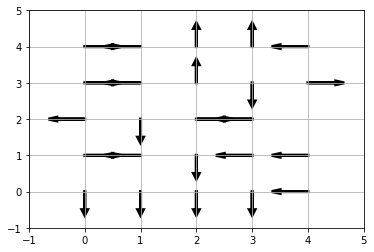

In [ ]:
Q.plot_table()

### Coding task

A présent, complétez la fonction suivante pour permettre le contrôle avec l'algorithme SARSA

In [ ]:

def SARSA_run(traj,Q,alpha,epsilon):
  grid = traj.grid
  size = grid.size
  grid.reboot()
  s0 = grid.state
  a0 = traj.get_action(Q,s0,epsilon)
  q0 = Q.get(s0,a0)
  t = 0
  err = 0
  while not grid.EOG and t<traj.T:
    if traj.show:
      traj.grid.plot_grid()
    r = grid.go(a0)
    s1 = grid.state
    a1 = traj.get_action(Q,s1,epsilon)
    q1 = Q.get(s1,a1)
    delta = r + traj.gamma*q1 - q0
    delta = min(1e2,delta) # clipping the TD error to avoid exploding gradient like phenomenon
    err += delta
    d = Q.get(s0,a0) + alpha*delta
    Q.update(s0,a0,np.squeeze(d))
    a0 = a1
    s0 = s1
    t+=1
  return Q, err/(t-1)



L'entraînement est légèrement différent (et plus simple) qu'avec l'approche MC.

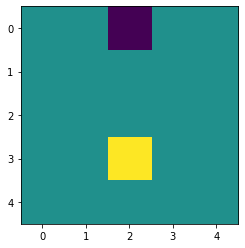

KeyboardInterrupt: ignored

In [ ]:
grid = GridWorld(start=[2,0],end=[2,4],r=-1e3)
traj = Trajectory(grid,show=0,T=1000)
Q = ActionStateTable(size=grid.size,values=0.,end=[2,4])
iter = 1000
update_every = 10
epsilon = 1
alpha = 1e-2
for i in range(iter):
  Q, err = traj.SARSA_run(Q,alpha,epsilon)
  if i%update_every==update_every-1:
    print(f'iter {i}/{iter} , mean delta : {err/update_every}')
    epsilon = epsilon*0.96
    print(f'epsilon = {epsilon}')
  if i == iter-10:
    traj.show = 1

Observons la politique à présent. Vous pouvez tester différentes configuration en faisant varier le point de départ et d'arriver dans le gridworld correspondant aux paramètres `start` et `end`

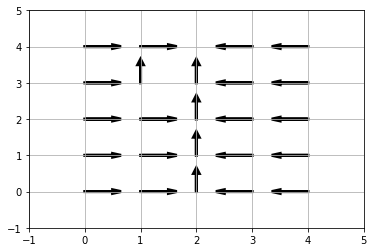

In [ ]:
Q.plot_table()

### Coding task

Complétez la fonction suivante correspondant à une trajectoire avec mise à jour de la valeur suivant l'algorithme Q-Learning

In [ ]:
def QLearning_run(traj,Q,alpha,epsilon):
  grid = traj.grid
  size = grid.size
  grid.reboot()
  t = 0
  err = 0
  s0 = grid.state
  while not grid.EOG and t<traj.T:
    if traj.show:
      traj.grid.plot_grid()
    a0 = traj.get_action(Q,s0,epsilon)
    q0 = Q.get(s0,a0)
    r = grid.go(a0)
    s1 = grid.state
    a1 = traj.get_action(Q,s1,0)
    q1 = Q.get(s1,a1)
    delta = r + traj.gamma*q1 - q0
    delta = min(1e2,delta) # clipping the TD error to avoid exploding gradient like phenomenon
    err += delta
    d = Q.get(s0,a0) + alpha*delta
    Q.update(s0,a0,np.squeeze(d))
    s0 = s1
    t+=1
  return Q, err/(t-1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Procédons enfin à l'entraîenemt avant d'observer la politique de l'agent

In [ ]:
grid = GridWorld(start=[2,0],end=[2,4],r=-1e3)
traj = Trajectory(grid,show=0,T=1000)
Q = ActionStateTable(size=grid.size,values=0.,end=[2,4])
iter = 1000
update_every = 10
epsilon = 1
alpha = 1e-2
for i in range(iter):
  Q, err = traj.QLearning_run(Q,alpha,epsilon)
  if i%update_every==update_every-1:
    print(f'iter {i}/{iter} , mean delta : {err/update_every}')
    epsilon = epsilon*0.96
    print(f'epsilon = {epsilon}')
  if i == iter-10:
    traj.show = 1